In [5]:
# Free throws between 2006 and 2016
import csv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['text.usetex'] = True

data_file = './data/free_throws.csv'
font_size = 30
font_size_legend = 25
font_size_ticks = 25

def load_data(player):
    free_throw_list = []
    with open(data_file, newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        for row in reader:
             if row[5] == player:
                 free_throw_list.append(int(row[9]))
    free_throws = np.array(free_throw_list)
    return free_throws

player = "Kevin Durant"

fraction_training_data = 0.5
free_throws = load_data(player)
print('First 10 free throws by ' + player + ":")
print(free_throws[:10])
n_free_throws = len(free_throws)
n_train = int(fraction_training_data * n_free_throws)
print("Number of training data: " + str(n_train))
print("Number of test data: " + str(n_free_throws-n_train))
train_data = free_throws[:n_train]
test_data = free_throws[n_train:]

First 10 free throws by Kevin Durant:
[0 1 0 1 0 1 1 1 1 0]
Number of training data: 3015
Number of test data: 3015


Streak lengths
[46. 43. 42. 30. 30. 21. 19. 11. 15. 19. 15.  7. 15.  7.  7.  6.  7.  5.
  2.  4.  3.  5.  1.  1.  5.  0.  2.  0.  2.  1.  0.  1.  0.  1.  0.  0.
  0.  0.  0.  1.  0.  0.  0.  0.  1.  1.  0.  0.  0.  0.  0.  0.  1.  0.
  0.]
Total streaks: 377.0


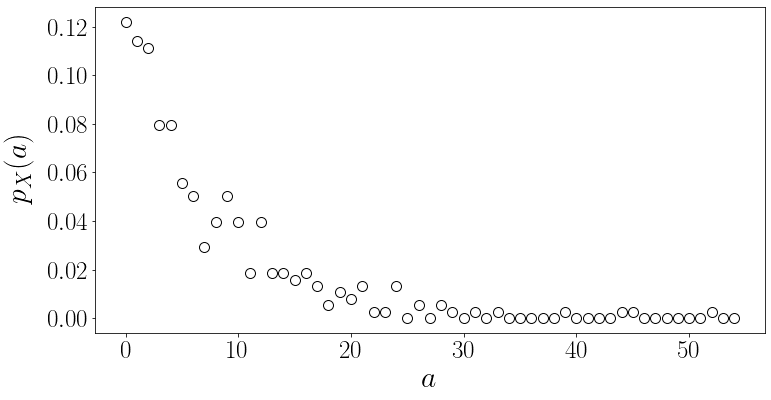

In [6]:
# Nonparametric modeling based on empirical pmf

n_max = 55 # Upper bound on streak length
def empirical_pmf(shots):
    consecutive = np.zeros(n_max)
    counter = 0
    for made in shots:
        if made == 0:
            consecutive[counter] += 1
            counter = 0
        else:
            counter +=1
    print("Streak lengths")
    print(consecutive)
    print("Total streaks: " + str(sum(consecutive)))
    consecutive_empirical_pmf = consecutive.astype(float) / float(np.sum(consecutive))
    return consecutive_empirical_pmf

empirical_pmf_train = empirical_pmf(train_data)

plt.figure(figsize=(12,6))
plt.plot(range(n_max),empirical_pmf_train[:n_max],'o',markersize=10,markerfacecolor='white',markeredgecolor="black")
plt.xticks(fontsize=font_size_ticks) 
plt.yticks(fontsize=font_size_ticks)
plt.ylabel(r"$p_{X}(a)$",fontsize=font_size,labelpad = 10)
plt.xlabel(r'$a$',fontsize=font_size)
plt.savefig('plots/free_throws_empirical_pmf.pdf',bbox_inches="tight")

ML parameter estimate: 0.875


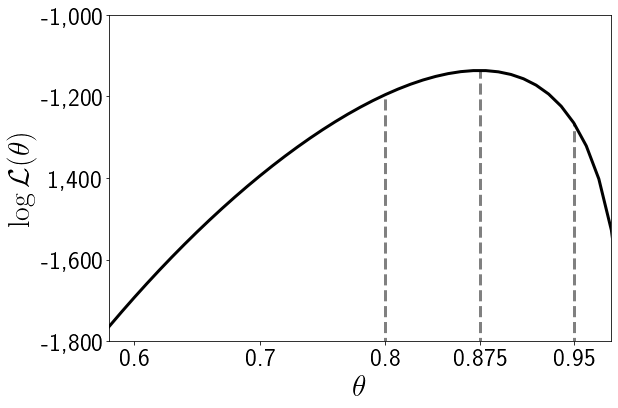

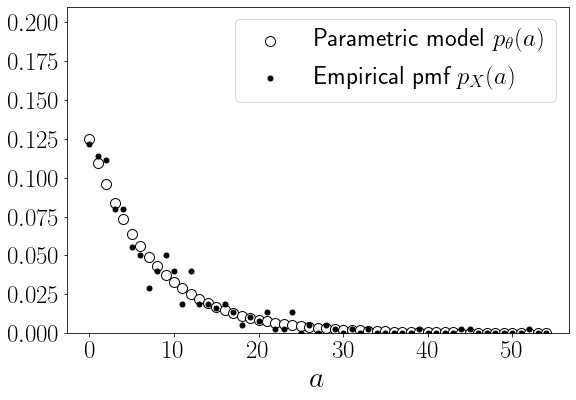

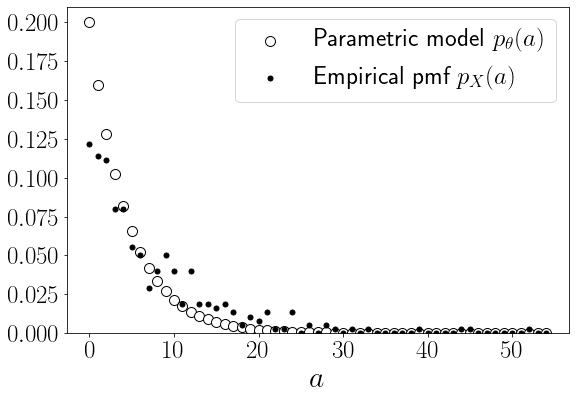

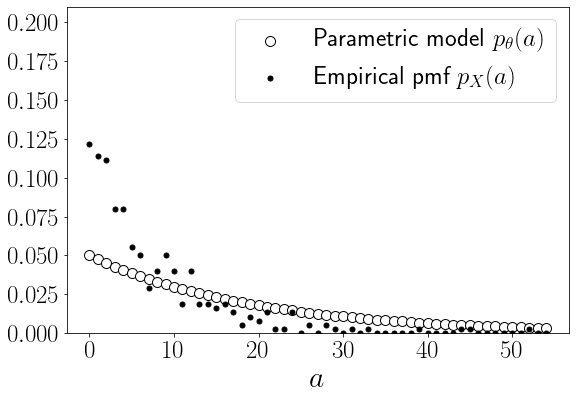

In [7]:
# Parametric modeling based on geometric model
def parametric_model(param):
    parametric_fit = (1-param) * param**(np.arange(n_max))
    return parametric_fit

# Log likelihood function
n_made = np.sum(train_data)
n_missed = len(train_data) - n_made
def log_likelihood(param):
    return n_made * np.log(param) + n_missed * np.log(1-param)

theta_vals = np.arange(0+1e-2,1,1e-2)
log_likelihood_vals = log_likelihood(theta_vals)

max_likelihood_param = np.mean(train_data)
print("ML parameter estimate: {:0.3f}".format(max_likelihood_param))
other_val_1 = 0.8
other_val_2 = 0.95

y_min = -1800
x_min = 0.6
plt.figure(figsize=(9,6))
plt.xticks(fontsize=font_size_ticks) 
plt.yticks(fontsize=font_size_ticks)
plt.plot(theta_vals,log_likelihood_vals,linewidth=3,color="black")
plt.vlines(max_likelihood_param, np.min(log_likelihood_vals), log_likelihood(max_likelihood_param), color="gray", linestyles='dashed',lw=3)
plt.vlines(other_val_1, np.min(log_likelihood_vals), log_likelihood(other_val_1), color="gray", linestyles='dashed',lw=3)
plt.vlines(other_val_2, np.min(log_likelihood_vals), log_likelihood(other_val_2), color="gray", linestyles='dashed',lw=3)
plt.ylim([y_min,-1000])
plt.xlim([x_min-0.02,0.98])
plt.xlabel(r'$\theta$',fontsize=font_size)
plt.ylabel(r'$\log \mathcal{L}(\theta)$',fontsize=font_size)
plt.xticks([0.6,0.7,other_val_1,0.875,other_val_2],labels=["0.6","0.7","0.8","0.875","0.95"])
plt.yticks([-1800,-1600,-1400,-1200,-1000],labels=["-1,800","-1,600","1,400","-1,200","-1,000"])
plt.savefig('plots/free_throws_loglikelihood.pdf',bbox_inches="tight")

parametric_fit_max_likelihood = parametric_model(max_likelihood_param)
parametric_fit_other_1 = parametric_model(other_val_1)
parametric_fit_other_2 = parametric_model(other_val_2)

y_max = 0.21
plt.figure(figsize=(9,6))
plt.xticks(fontsize=font_size_ticks) 
plt.yticks(fontsize=font_size_ticks)
plt.plot(range(n_max),parametric_fit_max_likelihood,'o',markersize=10,markerfacecolor='white',markeredgecolor="black",
     label=r'Parametric model $p_{\theta}(a)$')
plt.plot(range(n_max),empirical_pmf_train,'o',markersize=5,markerfacecolor='black',markeredgecolor="black",
     label=r'Empirical pmf $p_{X}(a)$')
plt.ylim([0,y_max])
plt.xlabel(r'$a$',fontsize=font_size)
plt.legend(fontsize=font_size_legend)
plt.savefig('plots/free_throws_parametric.pdf',bbox_inches="tight")

plt.figure(figsize=(9,6))
plt.xticks(fontsize=font_size_ticks) 
plt.yticks(fontsize=font_size_ticks)
plt.plot(range(n_max),parametric_fit_other_1,'o',markersize=10,markerfacecolor='white',markeredgecolor="black",
     label=r'Parametric model $p_{\theta}(a)$')
plt.ylim([0,y_max])
plt.plot(range(n_max),empirical_pmf_train,'o',markersize=5,markerfacecolor='black',markeredgecolor="black",
     label=r'Empirical pmf $p_{X}(a)$')
plt.xlabel(r'$a$',fontsize=font_size)
plt.legend(fontsize=font_size_legend)
plt.savefig('plots/free_throws_parametric_other_1.pdf',bbox_inches="tight")

plt.figure(figsize=(9,6))
plt.xticks(fontsize=font_size_ticks) 
plt.yticks(fontsize=font_size_ticks)
plt.plot(range(n_max),parametric_fit_other_2,'o',markersize=10,markerfacecolor='white',markeredgecolor="black",
     label=r'Parametric model $p_{\theta}(a)$')
plt.plot(range(n_max),empirical_pmf_train,'o',markersize=5,markerfacecolor='black',markeredgecolor="black",
     label=r'Empirical pmf $p_{X}(a)$')
plt.ylim([0,y_max])
plt.xlabel(r'$a$',fontsize=font_size)
plt.legend(fontsize=font_size_legend)
plt.savefig('plots/free_throws_parametric_other_2.pdf',bbox_inches="tight")


Streak lengths
[49. 42. 27. 34. 24. 21. 23. 16. 10. 15. 13.  6.  9.  6.  5.  8.  7.  6.
  1.  5.  6.  2.  1.  2.  4.  3.  1.  0.  3.  1.  3.  1.  0.  1.  1.  1.
  0.  1.  0.  1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.
  0.]
Total streaks: 360.0
Error of nonparametric estimate: 0.00767
Error of parametric estimate: 0.00561
Training error of parametric estimate: 0.00546


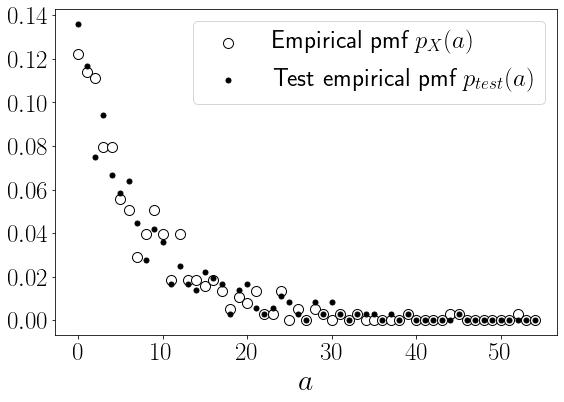

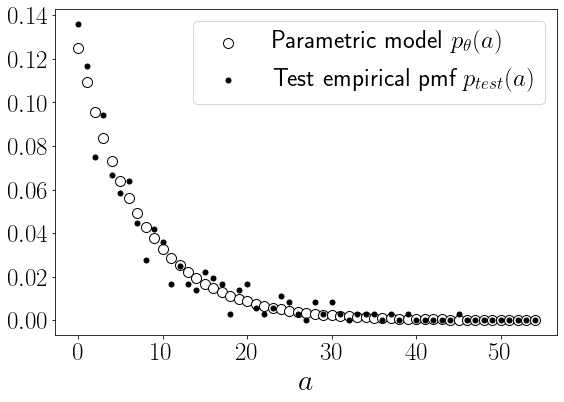

In [9]:
# Evaluation of nonparametric and parametric models using test data

empirical_pmf_test = empirical_pmf(test_data)

plt.figure(figsize=(9,6))
plt.xticks(fontsize=font_size_ticks) 
plt.yticks(fontsize=font_size_ticks)
plt.plot(range(n_max),empirical_pmf_train,'o',markersize=10,markerfacecolor='white',markeredgecolor="black",
     label=r'Empirical pmf $p_{X}(a)$')
plt.plot(range(n_max),empirical_pmf_test,'o',markersize=5,markerfacecolor='black',markeredgecolor="black",
     label=r'Test empirical pmf $p_{test}(a)$')
plt.xlabel(r'$a$',fontsize=font_size)
plt.legend(fontsize=font_size_legend)
plt.savefig('plots/free_throws_empirical_pmf_test.pdf',bbox_inches="tight")

plt.figure(figsize=(9,6))
plt.xticks(fontsize=font_size_ticks) 
plt.yticks(fontsize=font_size_ticks)
plt.plot(range(n_max),parametric_fit_max_likelihood,'o',markersize=10,markerfacecolor='white',markeredgecolor="black",
     label=r'Parametric model $p_{\theta}(a)$')
plt.plot(range(n_max),empirical_pmf_test,'o',markersize=5,markerfacecolor='black',markeredgecolor="black",
     label=r'Test empirical pmf $p_{test}(a)$')
plt.xlabel(r'$a$',fontsize=font_size)
plt.legend(fontsize=font_size_legend)
plt.savefig('plots/free_throws_parametric_test.pdf',bbox_inches="tight")

error_nonparametric = np.std(empirical_pmf_train - empirical_pmf_test)
error_parametric = np.std(parametric_fit_max_likelihood - empirical_pmf_test)
training_error_parametric = np.std(parametric_fit_max_likelihood - empirical_pmf_train)
print("Error of nonparametric estimate: {:0.5f}".format(error_nonparametric))
print("Error of parametric estimate: {:0.5f}".format(error_parametric))
print("Training error of parametric estimate: {:0.5f}".format(training_error_parametric))